In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Fluctuation analysis for adapted-levels algorithm
In this section we will do some analysis of the comportment of $\sqrt N\frac{\hat p - p}{p}$. In the idealized situation, by the thm of CTL, it converges to a normal law and we are interested in estimating the variance of this normal distribution.

In [5]:
# from numba import autojit
# @autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)

In [6]:
q_test = 8
from scipy.stats import norm
p = (1-norm.cdf(q_test))*2

p_0 = 0.3 #success rate
n_0 = int(np.log(p)/np.log(p_0))
r = p/(p_0**n_0)
sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
print ("theoretical relative standard variation: " + str(sigma_theoretical))
print ("real value of p: " + str(p))

theoretical relative standard variation: 8.12714373153
real value of p: 1.33226762955e-15


In [64]:
def mu_0_test(N):
    '''The distribution of X that we could simulate'''
    return np.random.normal(0,1,N)


def L_empirical(X,alpha, N, score_function):  
    return np.sort(score_function(X))[np.int((1-alpha)*N)]



# def shaker_test(X, sigma_1):
#     c = np.sqrt(1+sigma_1**2)
#     return np.random.normal(X/c,sigma_1/c,1)
    
def shaker_test(X, sigma_1): #metro polis hasting
    
    c = np.random.uniform(X - sigma_1, X + sigma_1,1)
    if np.random.rand(1) > np.exp(-0.5*(c**2-X**2)):
        return X
    else:
        return c
    




def simulation_adaptive_levels(real_p, p_0, N, mu_0, q_test, score_function = S, shake_times = 5, 
                              reject_rate = 0.3, sigma_default = 0.5,
                            descent_step = 0.02, status_track = False, shaker = shaker_test):
    ###### Initiation
    X = mu_0(N)
    L = np.array([-np.Inf,L_empirical(X ,p_0 ,N,score_function )])
    k = 1
    count_S = 0
    ###### 

    while(L[k]<q_test):
#         if status_track == True:
#             print ("\t")
#             print ("k = " + str(k))
#             print ('current level: ' + str(L[k]))
        I = []
        for i in range(N):
            if score_function(X[i])>L[k]:
                count_S +=1
                I = np.append(I, X[i])
        ell = len(I)
        if ell == 0:        ###### to ensure that I_k would not be empty
            break
        X[0:ell] = I
        

    ###### permutation trick to replace multinominal distribution
        #I = np.random.permutation(I)
        for i in range(ell,N,1):
            X[i] = I[i%ell]    
            
    ###### shaker
    ###### we will use an adaptive method to set the parameter of the shaker by
    ###### control the rejection rate.
        
        for index_shaker in range(shake_times):
            rate = 1.
            sigma_1 = sigma_default
            while(rate>reject_rate):

                reject = N - ell          #if we don't change the elements of I_k
                for j in range(ell,N,1):  
                #reject = N               #if we change the elements of I_k to have less dependence
                #for j in range(N):       

                    X_iter = shaker(X[j],sigma_1 = sigma_1)
                    if score_function(X_iter) > L[k]:
                        count_S += 1
                        X[j] = X_iter
                        reject -= 1.
                rate = reject/np.float(N - ell)
                #rate = reject/np.float(N) #if we change the elements of I_k to have less dependence
                
                sigma_1 -= descent_step
                if sigma_1 <= 0:
                    break
    ###### 
            
        
        L = np.append(L, L_empirical(X,p_0 ,N,score_function))
        k += 1
        
    N_L = np.sum((S(X)>q_test))
    p_hat = N_L/float(N)*p_0**(k-1)
    rel_var = (p_hat-real_p)/real_p
#     L_adapted = L[0:-1]
#     L_adapted = np.append(L_adapted, q_test)
    
    if status_track ==True:
        print ("final k = " + str(k))
        print ("real value of p:" + str(p))
        print ("estimation of p: " + str(p_hat))
        print ("sqrt(N) * relative variation: " + str(rel_var * np.sqrt(N)))
        print ('L_k = ' + str(L[k-1]) )
        print ("r = " + str(N_L/float(N)))
        print ('score function called : ' + str(count_S) + " times")
    return p_hat, rel_var,k


In [95]:
#test
from time import time
t_0 = time()
simulation_adaptive_levels(real_p = p, p_0 = 0.5, N = 50000, mu_0 = mu_0_test,
                           q_test = 8, status_track = True,sigma_default = 0.5,
                           descent_step = 0.1,reject_rate = 0.5,shake_times = 2)

print ("Time spent :"+ str(time() - t_0)+"s")

final k = 50
real value of p:1.33226762955e-15
estimation of p: 1.46137324464e-15
sqrt(N) * relative variation: 21.668989414
L_k = 7.9773176415
r = 0.82268
score function called : 2894558 times
Time spent :168.293175936s


In [42]:
list_N = [100,500,1000]
n_choice_N = len(list_N)
n_sim = 100
t_0 = time()
sim_N =[[ [] for j in range(n_sim)] for i in range(n_choice_N)]
print ("Total number of simulation: " + str(n_choice_N))
for index_sim in range(n_choice_N):
    for i in range(n_sim):
        sim_N[index_sim][i] = simulation_adaptive_levels(real_p = p ,p_0 = 0.75, N = list_N[index_sim],
                                  mu_0 = mu_0_test, q_test = 8, score_function = S, 
                                                        status_track = False, descent_step = 0.1)
        
    print ("simulation completed: "+ str(index_sim+1))
sim_N = np.array(sim_N)
print ("Time spent :"+ str(time() - t_0)+"s")

Total number of simulation: 3


KeyboardInterrupt: 

In [14]:
estimation_sim = np.array([sim_N[i][:,0] for i in range(n_choice_N)])
sigma_relative_variation_sim = np.array([sim_N[i][:,1] * np.sqrt(list_N[i]) for i in range(n_choice_N)]) 
print ("theoretical std of relative variation: " + str(sigma_theoretical))
std_sqrtN = np.array([np.std(sigma_relative_variation_sim[i]) for i in range(n_choice_N)])
print ("\sqrt N * std of relative variation : " + str(std_sqrtN ))

theoretical std of relative variation: 6.29956760627
\sqrt N * std of relative variation : [ 28.47996866   8.72932333   7.1513569 ]


## Fluctuation Analysis

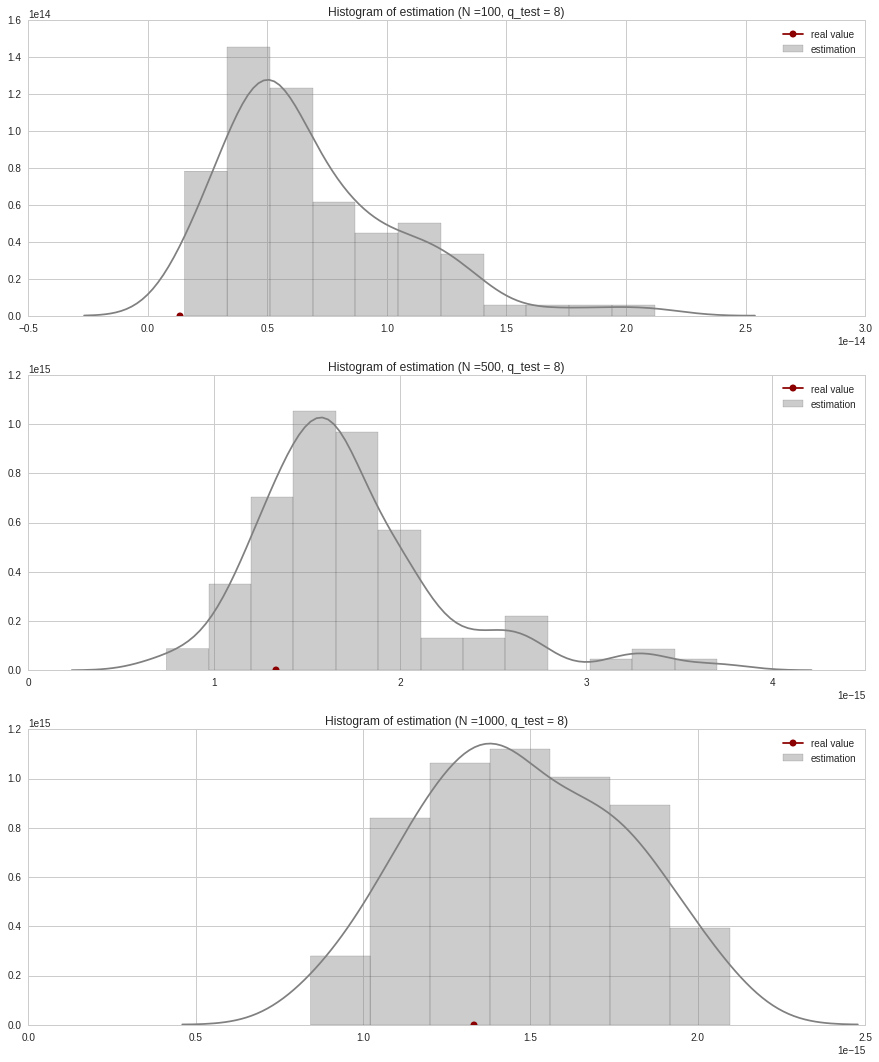

In [15]:
##fluctuation
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(estimation_sim[i] , label = "estimation",color = "grey")
    plt.title('Histogram of estimation (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-1,1,0.1)
    plt.plot(p,0,marker = "o",color = 'darkred',label = "real value")
    plt.legend()
    #plt.xlim([-0.3,0.3])




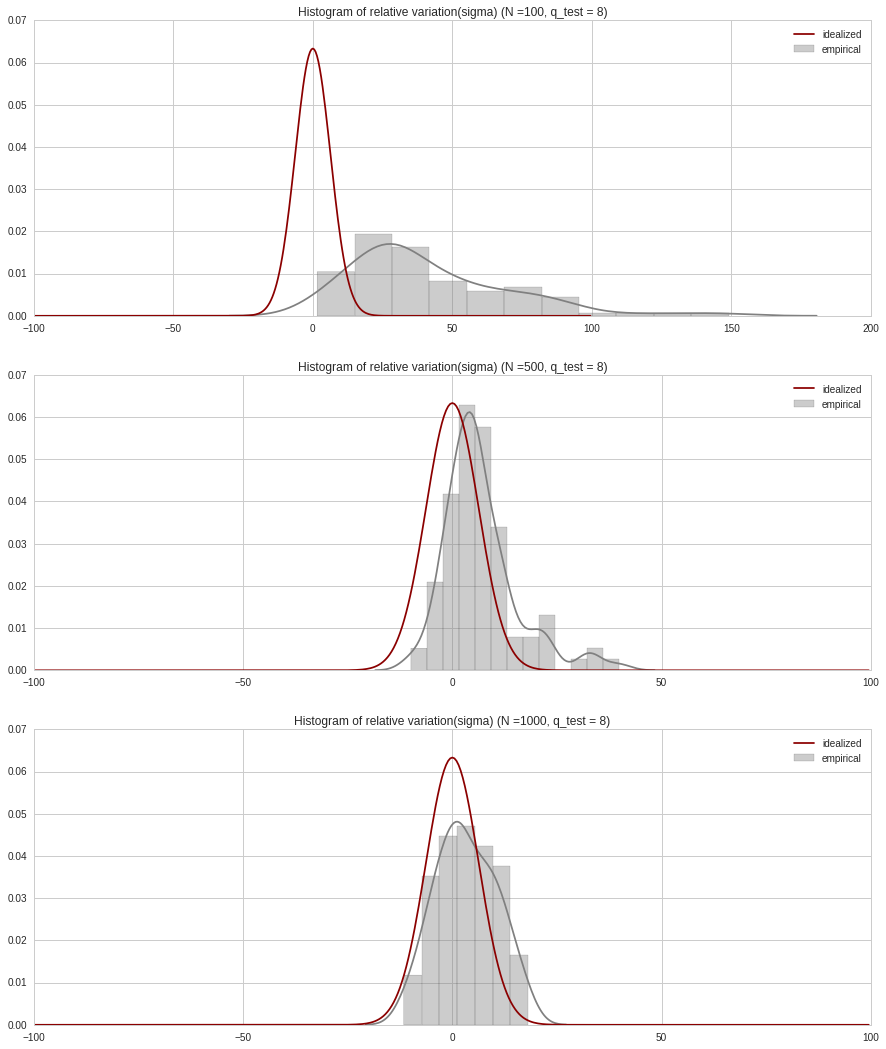

In [16]:
##fluctuation of variance(sigma)
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(sigma_relative_variation_sim[i] , label = "empirical", color = "grey")
    plt.title('Histogram of relative variation(sigma) (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-100,100,0.5)
    plt.plot(x,norm.pdf(x,np.float(1/list_N[i])*(1-p_0)/p_0,sigma_theoretical), label = "idealized", color = "darkred")
    plt.legend()
    #plt.xlim([-5000,5000])




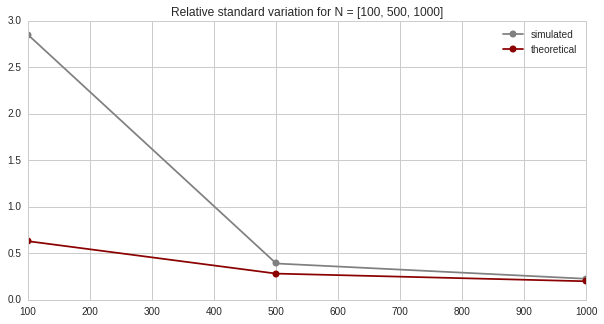

In [17]:
plt.figure(figsize = [10,5])
plt.plot(list_N, std_sqrtN/ np.sqrt(list_N), label = "simulated", marker = 'o',color ="grey")
plt.plot(list_N,  sigma_theoretical /np.sqrt(list_N), label = "theoretical", marker = 'o' ,color ="darkred"   ) 
plt.legend()
plt.title("Relative standard variation for N = "+str(list_N))

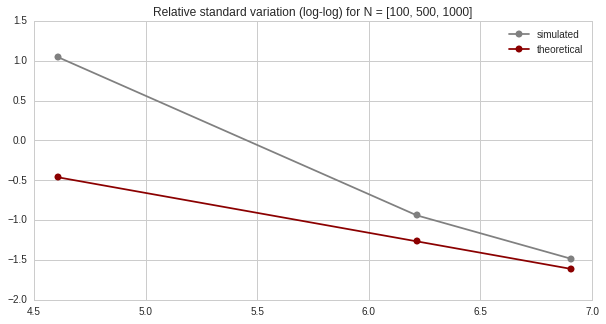

In [18]:
plt.figure(figsize = [10,5])
plt.plot(np.log(list_N), np.log(std_sqrtN/ np.sqrt(list_N)), label = "simulated", marker = 'o',color = "grey")
plt.plot(np.log(list_N),  np.log(sigma_theoretical /np.sqrt(list_N)), label = "theoretical", marker = 'o' ,color = "darkred" ) 
plt.legend()
plt.title("Relative standard variation (log-log) for N = "+str(list_N))

# trick

In [96]:
def mu_0_test(N):
    '''The distribution of X that we could simulate'''
    return np.random.normal(0,1,N)


def L_empirical(X,alpha, N, score_function):  
    return np.sort(score_function(X))[np.int((1-alpha)*N)]



def shaker_test(X, sigma_1):
    c = np.sqrt(1+sigma_1**2)
    return np.random.normal(X/c,sigma_1/c,1)
    




def simulation_adaptive_levels_trick(real_p, p_0, N, mu_0, q_test, score_function = S, shake_times = 5, 
                              reject_rate = 0.3, sigma_default = 0.5,
                            descent_step = 0.02, status_track = False, shaker = shaker_test):
    ###### Initiation
    X = mu_0(N)
    L = np.array([-np.Inf,L_empirical(X ,p_0 ,N,score_function )])
    k = 1
    sim_p = []
    sim_var = []
    ###### 

    while(L[k]<q_test):
#         if status_track == True:
#             print ("\t")
#             print ("k = " + str(k))
#             print ('current level: ' + str(L[k]))
        I = []
        for i in range(N):
            if S(X[i])>L[k]:
                I = np.append(I, X[i])
        ell = len(I)
        if ell == 0:        ###### to ensure that I_k would not be empty
            break
        X[0:ell] = I
        

    ###### permutation trick to replace multinominal distribution
        I = np.random.permutation(I)
        for i in range(ell,N,1):
            X[i] = I[i%ell]    
            
    ###### shaker
    ###### we will use an adaptive method to set the parameter of the shaker by
    ###### control the rejection rate.
        
        for index_shaker in range(shake_times):
            rate = 1.
            sigma_1 = sigma_default
            while(rate>reject_rate):

                reject = N - ell          #if we don't change the elements of I_k
                for j in range(ell,N,1):  
                #reject = N               #if we change the elements of I_k to have less dependence
                #for j in range(N):       

                    X_iter = shaker(X[j],sigma_1 = sigma_1)
                    if score_function(X_iter) > L[k]:
                        X[j] = X_iter
                        reject -= 1.
                rate = reject/np.float(N - ell)
                #rate = reject/np.float(N) #if we change the elements of I_k to have less dependence
                
                sigma_1 -= descent_step
                if sigma_1 <= 0:
                    break
    ###### 
            
        
        L = np.append(L, L_empirical(X,p_0 ,N,score_function))
        k += 1
        
    N_L = np.sum((score_function(X)>q_test))
    p_hat = N_L/float(N)*p_0**(k-1)
    sim_p = np.append(sim_p,p_hat)
    rel_var = (p_hat-real_p)/real_p
    sim_var = np.append(sim_var,rel_var)
    
    for index_sim in range(100):
        for index_shaker in range(shake_times):
            rate = 1.
            sigma_1 = sigma_default
            while(rate>reject_rate):

                  
                reject = N               #if we change the elements of I_k to have less dependence
                for j in range(N):       

                    X_iter = shaker(X[j],sigma_1 = sigma_1)
                    if score_function(X_iter) > L[k-1]:
                        X[j] = X_iter
                        reject -= 1.
                
                rate = reject/np.float(N) #if we change the elements of I_k to have less dependence
                
                sigma_1 -= descent_step
                if sigma_1 <= 0:
                    break
        N_L = np.sum((score_function(X)>q_test))
        p_hat = N_L/float(N)*p_0**(k-1)
        sim_p = np.append(sim_p,p_hat)
        rel_var = (p_hat-real_p)/real_p
        sim_var = np.append(sim_var,rel_var)
    
    
    
    
    rel_var = (p_hat-real_p)/real_p
#     L_adapted = L[0:-1]
#     L_adapted = np.append(L_adapted, q_test)
    
    if status_track ==True:
        print ("final k = " + str(k))
        print ("real value of p:" + str(p))
        print ("estimation of p: " + str(p_hat))
        print ("sqrt(N) * relative variation: " + str(rel_var * np.sqrt(N)))
    return sim_p, sim_var



In [735]:
#test
from time import time
t_0 = time()
a = simulation_adaptive_levels_trick(real_p = p, p_0 = 0.1, N = 5000, mu_0 = mu_0_test,
                    
                          q_test = 8, status_track = True,descent_step = 0.1,reject_rate = 0.5,shake_times = 10)

print ("Time spent :"+ str(time() - t_0)+"s")

final k = 15
real value of p:1.33226762955e-15
estimation of p: 1.094e-15
sqrt(N) * relative variation: -12.6461570375
Time spent :683.423820972s


0.0358728479255


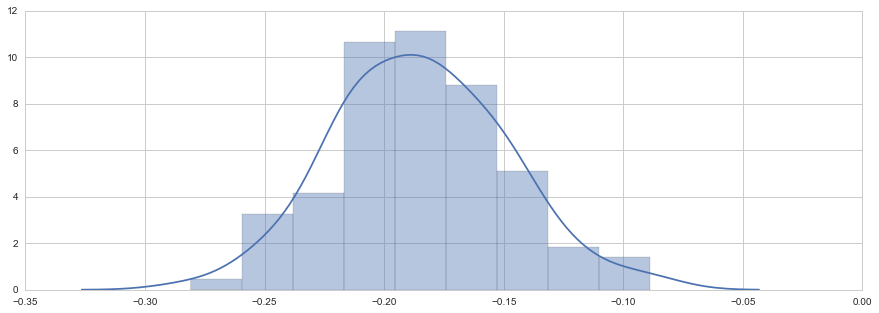

In [736]:
plt.figure(figsize = [15,5])
sns.distplot(a[1])
print np.std(a[1])

In [737]:
np.mean(a[0])

1.0856831683168327e-15

In [738]:
a[0][0]

1.1040000000000008e-15

In [743]:
#test
from time import time
t_0 = time()
a = [[] for i in range(100)]
for i in range(100):
    a[i] = simulation_adaptive_levels(real_p = p, p_0 = 0.1, N = 500, mu_0 = mu_0_test, 
                                   q_test = 8, status_track = True,descent_step = 0.1,reject_rate = 0.5,shake_times = 10)

print ("Time spent :"+ str(time() - t_0)+"s")

final k = 15
real value of p:1.33226762955e-15
estimation of p: 1.96e-15
sqrt(N) * relative variation: 10.5358129318
L_k = 7.79182557822
r = 0.196
final k = 16
real value of p:1.33226762955e-15
estimation of p: 5.14e-16
sqrt(N) * relative variation: -13.7337424019
L_k = 7.91393324615
r = 0.514
final k = 15
real value of p:1.33226762955e-15
estimation of p: 1.72e-15
sqrt(N) * relative variation: 6.5076709677
L_k = 7.75580161229
r = 0.172
final k = 15
real value of p:1.33226762955e-15
estimation of p: 1.52e-15
sqrt(N) * relative variation: 3.15088599762
L_k = 7.75626959932
r = 0.152
final k = 15
real value of p:1.33226762955e-15
estimation of p: 1.9e-15
sqrt(N) * relative variation: 9.52877744077
L_k = 7.76178407993
r = 0.19
final k = 15
real value of p:1.33226762955e-15
estimation of p: 2.66e-15
sqrt(N) * relative variation: 22.2845603271
L_k = 7.82237567563
r = 0.266
final k = 16
real value of p:1.33226762955e-15
estimation of p: 5.54e-16
sqrt(N) * relative variation: -13.0623854079
L_

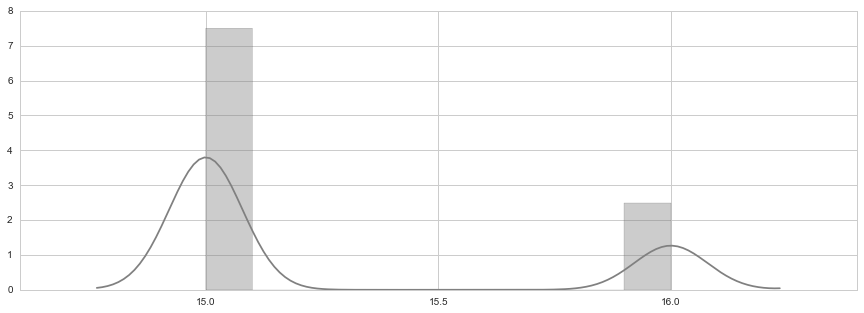

In [748]:
plt.figure(figsize = [15,5])
sns.distplot([a[i][2] for i in range(100)], hist = True, color = 'grey')


type